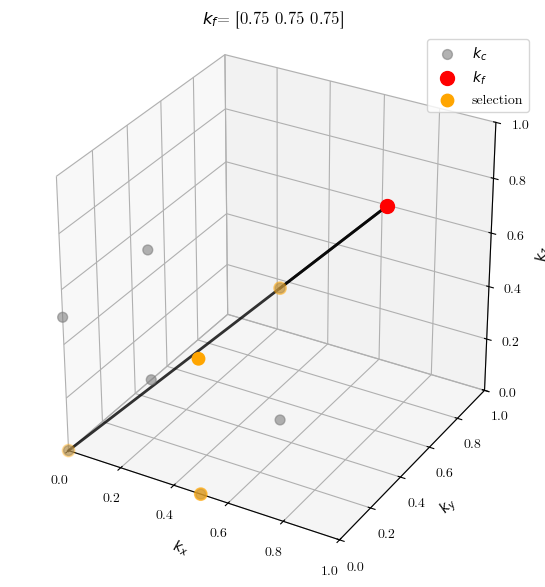

In [10]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.spatial import Delaunay

# ——— Use CMU Serif for all text ———
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['CMU Serif']

def closestpts(fine_kpt, coarse_kpts, periodic=True):
    if periodic:
        shifts = np.array(np.meshgrid([-1, 0, 1],
                                      [-1, 0, 1],
                                      [-1, 0, 1])).reshape(3, -1).T

        tiled_kpts = []
        tiled_indices = []
        for shift in shifts:
            shifted = coarse_kpts + shift    # keep in extended cell
            tiled_kpts.append(shifted)
            tiled_indices.append(np.arange(len(coarse_kpts)))

        tiled_kpts   = np.vstack(tiled_kpts)
        tiled_indices = np.hstack(tiled_indices)

        tri = Delaunay(tiled_kpts, qhull_options="Qz")
        simplex = tri.find_simplex(fine_kpt)
        if simplex == -1:
            raise RuntimeError("Delaunay failed to cover the periodic cell.")

        T = tri.transform[simplex]
        X = fine_kpt - T[3]
        lam = T[:3].dot(X)
        weights = np.append(lam, 1 - lam.sum())

        vertex_ids = tri.simplices[simplex]
        indices = tiled_indices[vertex_ids]

    else:
        tri = Delaunay(coarse_kpts, qhull_options="Qz")
        simplex = tri.find_simplex(fine_kpt)
        if simplex == -1:
            d2 = np.sum((coarse_kpts - fine_kpt)**2, axis=1)
            idx = np.argmin(d2)
            return np.array([idx]), np.array([1.0])
        T = tri.transform[simplex]
        X = fine_kpt - T[3]
        lam = T[:3].dot(X)
        weights = np.append(lam, 1 - lam.sum())
        indices = tri.simplices[simplex]

    return indices, weights  


# ——— build coarse (2×2×2) and fine (4×4×4) grids ———
coarse_kpts = np.array(list(np.ndindex(2,2,2))) / 2.0
fine_coords = np.array(list(np.ndindex(4,4,4))) / 4.0
N = len(fine_coords)

# ——— set up 3D figure & axis ———
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))
ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_zlim(0,1)
ax.set_xlabel(r'$k_x$'); ax.set_ylabel(r'$k_y$'); ax.set_zlabel(r'$k_z$')

ax.scatter(coarse_kpts[:,0],
           coarse_kpts[:,1],
           coarse_kpts[:,2],
           c='gray', s=50, alpha=0.6,
           label=r'$k_c$')

scatter_fine = ax.scatter([], [], [], c='red',  s=100, label=r'$k_f$')
vertex_scat  = ax.scatter([], [], [], c='orange', s=80,  label='selection')
lines = []

def update(frame):
    global lines
    for ln in lines:
        ln.remove()
    lines = []

    kp = fine_coords[frame]
    indices, weights = closestpts(kp, coarse_kpts, periodic=True)
    verts = coarse_kpts[indices]

    scatter_fine._offsets3d = ([kp[0]], [kp[1]], [kp[2]])
    vertex_scat._offsets3d = (verts[:,0], verts[:,1], verts[:,2])

    for v, w in zip(verts, weights):
        ln, = ax.plot([kp[0], v[0]],
                      [kp[1], v[1]],
                      [kp[2], v[2]],
                      linewidth=4*w, alpha=0.8, color='black')
        lines.append(ln)

    ax.set_title(rf"$k_f$= {kp}")
    return [scatter_fine, vertex_scat] + lines

# ——— slower animation: interval=800ms, fps=2 ———
ani = FuncAnimation(fig, update, frames=N, interval=800, blit=False)
plt.legend(loc='upper right')
ani.save("interp_barycentric_periodic.gif", writer=PillowWriter(fps=2))

plt.tight_layout()
plt.show()
